## CNN  en sepecifier une station

In [7]:
from tensorflow.keras import layers, callbacks, optimizers,models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



traite time serise data 

In [8]:
file_path = 'merged_bike_44_weather_events.csv'
data = pd.read_csv(file_path)
## add caractère time
data['hour'] = pd.to_datetime(data['timestamp']).dt.hour
data['day_of_week'] = pd.to_datetime(data['timestamp']).dt.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

## line comme entre
data = data.set_index('timestamp')


In [9]:


X = data.drop(columns=['available_bikes','available_bike_stands'])  
y = data['available_bikes']

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2,shuffle=False)

X_train = X_train.reshape((X_train.shape[0],1, X_train.shape[1]))
#(nombre_station , longgeur de serie , nombre feature)
X_test = X_test.reshape((X_test.shape[0],1, X_test.shape[1]))
test_timestamps = data.index[X_test.shape[0] * -1:]  

test_timestamps = test_timestamps[:len(y_test)]

print(X_train.shape)
print(test_timestamps)

(2481, 1, 12)
Index(['2025-01-01T09:45:00.000+01:00', '2025-01-02T16:00:00.000+01:00',
       '2025-01-04T17:45:00.000+01:00', '2025-01-08T15:30:00.000+01:00',
       '2025-01-08T19:30:00.000+01:00', '2025-01-08T20:00:00.000+01:00',
       '2025-01-10T10:45:00.000+01:00', '2025-01-11T07:15:00.000+01:00',
       '2025-01-14T01:00:00.000+01:00', '2025-01-14T08:45:00.000+01:00',
       ...
       '2024-12-26T19:15:00.000+01:00', '2024-12-27T21:15:00.000+01:00',
       '2024-12-28T22:00:00.000+01:00', '2025-01-03T03:30:00.000+01:00',
       '2025-01-04T00:30:00.000+01:00', '2025-01-05T09:30:00.000+01:00',
       '2025-01-07T04:00:00.000+01:00', '2025-01-08T15:45:00.000+01:00',
       '2025-01-09T11:45:00.000+01:00', '2025-01-10T04:00:00.000+01:00'],
      dtype='object', name='timestamp', length=621)


definir data et model

In [10]:


model = models.Sequential([
    layers.Conv1D(32, kernel_size=2, activation='relu', padding='same', 
                  input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='linear')
])
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae', 'mse']
)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 32)             800       
                                                                 
 batch_normalization (Batch  (None, 1, 32)             128       
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 32)                0

fit

Training the model...
Epoch 1/30
140/140 [==============================] - 8s 12ms/step - loss: 0.3911 - mae: 0.4699 - val_loss: 0.0982 - val_mae: 0.2762 - lr: 0.0010
Epoch 2/30
140/140 [==============================] - 1s 10ms/step - loss: 0.1425 - mae: 0.2992 - val_loss: 0.0753 - val_mae: 0.2287 - lr: 0.0010
Epoch 3/30
140/140 [==============================] - 1s 9ms/step - loss: 0.0937 - mae: 0.2419 - val_loss: 0.0501 - val_mae: 0.1760 - lr: 0.0010
Epoch 4/30
140/140 [==============================] - 1s 9ms/step - loss: 0.0808 - mae: 0.2245 - val_loss: 0.0447 - val_mae: 0.1701 - lr: 0.0010
Epoch 5/30
140/140 [==============================] - 1s 8ms/step - loss: 0.0681 - mae: 0.2080 - val_loss: 0.0432 - val_mae: 0.1639 - lr: 0.0010
Epoch 6/30
140/140 [==============================] - 1s 10ms/step - loss: 0.0601 - mae: 0.1946 - val_loss: 0.0412 - val_mae: 0.1597 - lr: 0.0010
Epoch 7/30
140/140 [==============================] - 1s 11ms/step - loss: 0.0572 - mae: 0.1902 - val_los

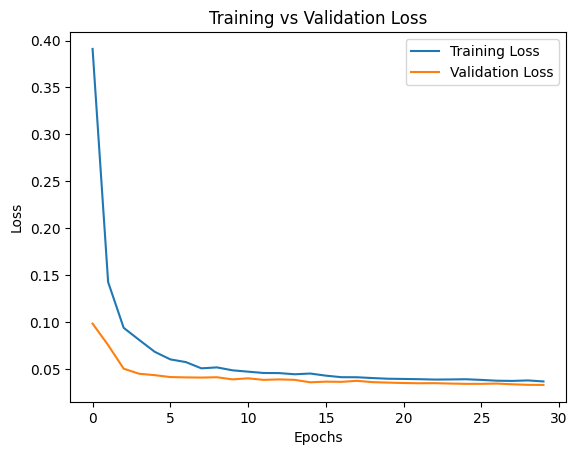

20/20 [==============================] - 1s 5ms/step


In [11]:

print("Training the model...")
callback_list = [
     callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-5
    )
]

history=model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1, shuffle=False,callbacks=callback_list)


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()
predictions = model.predict(X_test)

y_test_original = scaler_y.inverse_transform(y_test) 
y_pred = scaler_y.inverse_transform(predictions)   
total_bike_stands = data['available_bike_stands'] + data['available_bikes']  
total_bike_stands = total_bike_stands.iloc[0]  
y_pred_stands = total_bike_stands - y_pred  
y_test_stands = total_bike_stands - y_test_original 


figure

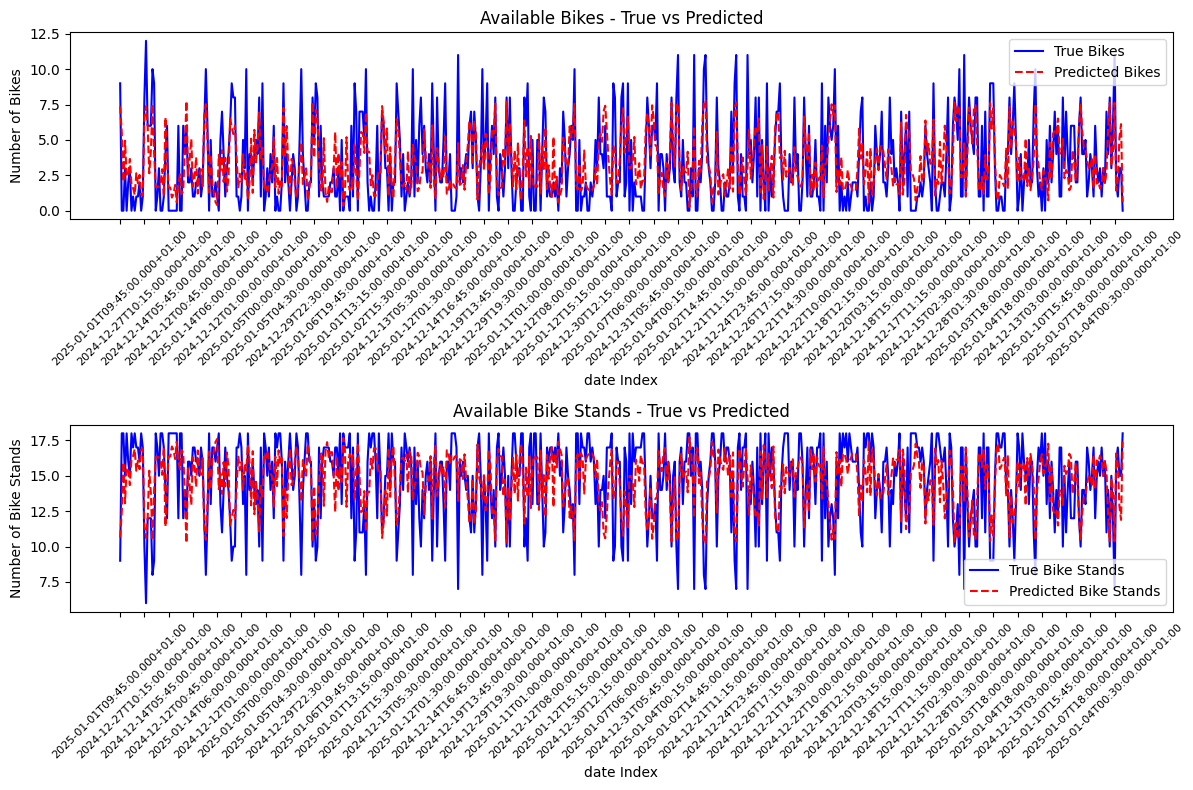

In [12]:

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(test_timestamps,y_test_original, label='True Bikes', color='blue')
plt.plot(test_timestamps,y_pred, label='Predicted Bikes', linestyle='--', color='red')
plt.title('Available Bikes - True vs Predicted')
plt.xlabel('date Index')
plt.ylabel('Number of Bikes')
plt.legend()
plt.xticks(ticks=np.arange(0, len(test_timestamps), step=15), 
           labels=test_timestamps[::15], 
           rotation=45, fontsize=8) 
plt.subplot(2, 1, 2)
plt.plot(test_timestamps,y_test_stands, label='True Bike Stands', color='blue')
plt.plot(test_timestamps,y_pred_stands, label='Predicted Bike Stands', linestyle='--', color='red')
plt.title('Available Bike Stands - True vs Predicted')
plt.xlabel('date Index')
plt.ylabel('Number of Bike Stands')
plt.legend()
plt.xticks(ticks=np.arange(0, len(test_timestamps), step=15), 
           labels=test_timestamps[::15], 
           rotation=45, fontsize=8) 
plt.tight_layout()
plt.show()

In [13]:
print("(",X_train.shape[0],",",X_train.shape[1],",",X_train.shape[2],")")

r2 = r2_score(y_test, predictions)
print("R² Score:", r2)


mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)

( 2481 , 1 , 12 )
R² Score: 0.508258052500048
Mean Absolute Error (MAE): 0.1366549237134856


export model 

In [29]:
import joblib
model.save('cnn_model.h5')
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

d:\CODE\code_python\integre\cnn\envCnn\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['scaler_y.pkl']